### Preamble

In [ ]:
import findspark, os
os.environ['SPARK_HOME'] = "/usr/local/spark"
findspark.init()
import pyspark
from pyspark import SparkContext
from thunder.utils.context import ThunderContext

sc = SparkContext(master='spark://spark-master:7077')
tsc = ThunderContext(sc)

### Imports and setup

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
# import mpld3

# Setup for plotting
from thunder import Colorize
image = Colorize.image
%matplotlib inline
sns.set_context('notebook')
# mpld3.enable_notebook()

# include files from a specific directory (e.g. user Python code)
import sys
import os
sys.path.append(os.getcwd())

# only required on cluster (ships required py-files to workers)
# sc.addPyFile('/cluster/home02/sdid/hluetcke/Data/Projects/NeuroPipeline/CalciumAnalysisUtils.py')

# Check if we have a thunder context running
try:
    tsc
except NameError:
    print "Could not find tsc. Start notebook with thunder command!"

### Function definitions

In [2]:
# Function readMetadata
# read metadata json file and return content as Python dict
import json
def readMetadata(filename):
    json_data = open(jsonfile).read()
    metadata = json.loads(json_data)
    return metadata

In [3]:
def convolveStimWithCalciumResponse(stim, t, tauOn, tauOff):
    # canonical calcium indicator response
    # tauOn ... onset time in s
    # tauOff ... offset time in s
    signal = (1-(np.exp(-t/tauOn)))*(np.exp(-(t/tauOff)));
    # plt.plot(t, signal);
    # convolve stimulus with the canonical calcium indicator response
    stim_conv = np.convolve(stim, signal)
    stim_conv = np.delete(stim_conv, range(len(stim),len(stim_conv)))
    # plt.plot(t, stim)
    # plt.plot(t, stim_conv)
    return stim_conv

In [4]:
def psAnalysis(data, stim, baseFrames, evokedFrames):
    # figure out number of unique stims
    stimID = stim[stim>0]
    stimID = np.unique(stimID)
    nUniqueStims = len(np.unique(stimID))
    for nStim in stimID:
        stimIx = np.where(stim==nStim)
        stimIx = stimIx[0]
        pos = 1
        for nStim2 in stimIx:
            startFrame = nStim2 - baseFrames
            stopFrame = nStim2 + evokedFrames
            if pos == 1:
                psData = data[startFrame:stopFrame]
            else:
                psData = np.vstack((psData, data[startFrame:stopFrame]))
            pos = pos + 1
        if nStim == 1:
            psDataAllStims = [psData]
        else:
            psDataAllStims.append(psData)
    return psDataAllStims

### Data import
Read ROI / stim data and header file

In [5]:
# read Matlab data into thunder Series object
# reading .mat files is only supported on local file system, for HDFS either binary or text file input is required
dataPath = '/Users/Henry/polybox/Data_temp/NeuroPipeline/test/Monyer_Leitner_F296'
# fileID = 'Monyer_Leitner_F296_spot01_20140224143233'
fileID = 'spotData'
matfile = dataPath + '/' + fileID + '.mat'
# json file contains header information
jsonfile = dataPath + '/' + fileID + '.json'

In [6]:
# load ROI data
roiData = tsc.loadSeries(matfile, inputFormat='mat', varName='roiData')
# load Stimulus data (maybe not necessary as tsc series?)
stimData = tsc.loadSeries(matfile, inputFormat='mat', varName='stimData')
stimData = stimData.get(0)
# read header
# read json file with metadata
metadata = readMetadata(jsonfile)
# also load the reference image from the mat file
refImage = sp.io.loadmat(matfile, variable_names='refImage')
refImage = refImage['refImage']
refImage = refImage[0][0]

### Plot the current data set

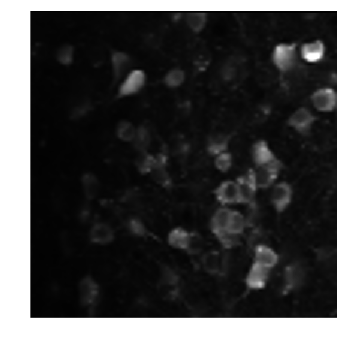

In [7]:
# plot image of the current population
image(refImage, clim=(0,100))

(0, 1470.0)

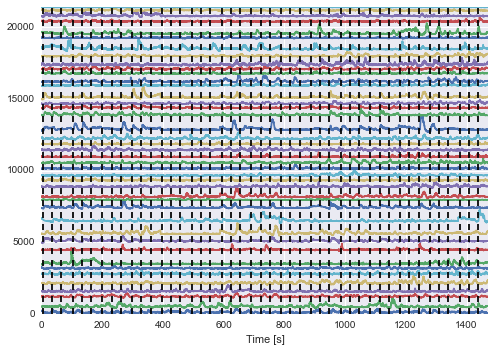

In [8]:
# Plot timeseries
nNeurons = roiData.nrecords
nTimepoints = roiData.index.shape[0]
# define frequency in Hz
f = 5
roiData.index = np.linspace(1/f, nTimepoints/f, nTimepoints)
offset = 0
for n in range(nNeurons):
    plotTrace = roiData[n]
    plotTrace = plotTrace - min(plotTrace) + offset
    offset = max(plotTrace)
    plt.plot(roiData.index, plotTrace)
for n in range(nTimepoints):
    if stimData[n]:
        tStim = roiData.index[n]
        plt.plot((tStim, tStim), (0, offset), 'k--')
plt.xlabel('Time [s]')
plt.ylim((0, offset))
plt.xlim((0, np.max(roiData.index)))
# plt.savefig('Timeseries_AllStim.png')

/Users/Henry/miniconda/envs/thunder_env/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


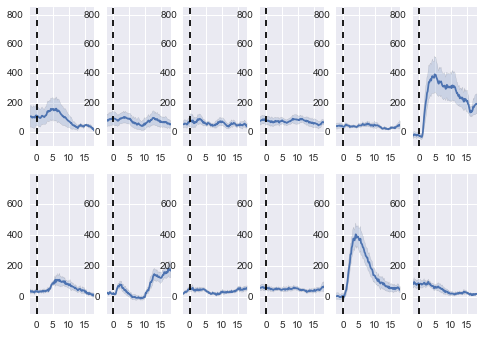

In [9]:
# first add the CalciumAnalysisUtils to the workers' pythonpath
sc.addPyFile('./CalciumAnalysisUtils.py')
from CalciumAnalysisUtils import psAnalysis

# PS Plots
baseFrames = 10
evokedFrames = 100

# compute PSdata for all neurons
psData = roiData.apply(lambda (k, v): (k, psAnalysis(v, stimData, (baseFrames, evokedFrames))))

roisToPlot = (11, 28)
# roisToPlot = range(nNeurons)
splotCounter = 1
for n in roisToPlot:
#     psDataByStim = psAnalysis(roiData[n], stimData, baseFrames, evokedFrames)
    psDataByStim = psData[n]
    # same y range for all stims
    minY = min([ np.min(x) for x in psDataByStim ])
    maxY = max([ np.max(x) for x in psDataByStim ])
    for iStim in psDataByStim:
        meanData = np.mean(iStim,axis=0)
        semData = np.std(iStim,axis=0) / np.sqrt(np.shape(iStim)[0])
        lo= meanData-semData
        hi = meanData+semData
        t = (np.linspace(0, evokedFrames, meanData.size)-baseFrames)/f
        plt.subplot(len(roisToPlot), len(psDataByStim), splotCounter)
        splotCounter = splotCounter + 1
        plt.fill_between(t, lo, hi, alpha=0.2)
        plt.plot(t, meanData)
        plt.plot((0,0), (minY, maxY), 'k--')
        plt.xlim((min(t), max(t)))
        plt.ylim((minY, maxY))
# plt.savefig('PsPlot_AllStims.eps')

### Correlation analysis

Correlate each ROI timeseries with the stimulus

TODOs:
* Map of correlation coefficients

In [14]:
# ignore type of stimulus
stim = stimData.copy()
stim[stim>0] = 1
# convolve stim with calcium response
tauOn = 0.5
tauOff = 5
stim_conv = convolveStimWithCalciumResponse(stim, roiData.index, tauOn, tauOff)
corrs = roiData.correlate(stim_conv)
cc = corrs.collectValuesAsArray()

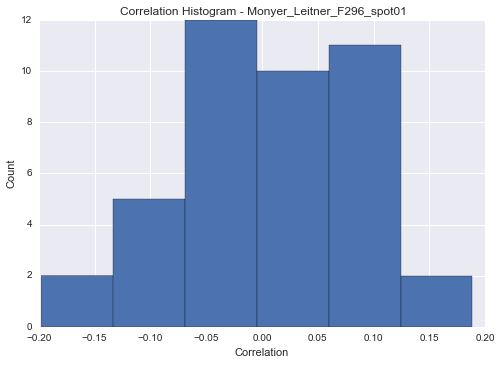

In [12]:
# histogram of correlation values
n, bins, patches = plt.hist(cc, np.sqrt(len(cc)).astype('int'));
plt.xlabel('Correlation');
plt.ylabel('Count');
plt.title('Correlation Histogram - %s' % metadata['UUID']);

### Regression analysis

Linear regression of stimulus vector against the timeseries data for each ROI

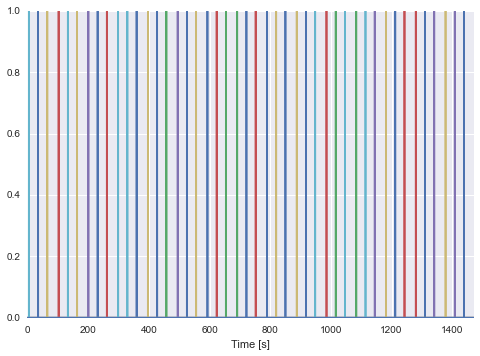

In [15]:
# build design matrix from stimulus vector
stimId = stimData[stimData>0]
stimIx = np.where(stimData>0)
stimIx = stimIx[0]
nStims = len(np.unique(stimId))
X = np.zeros((nStims, nTimepoints), int)
for iStim in range(len(stimIx)):
    X[stimId[iStim]-1, stimIx[iStim]] = 1
# plot stimulus matrix
plt.plot(roiData.index, X.T);
plt.xlim((0, np.max(roiData.index)));
plt.xlabel('Time [s]');

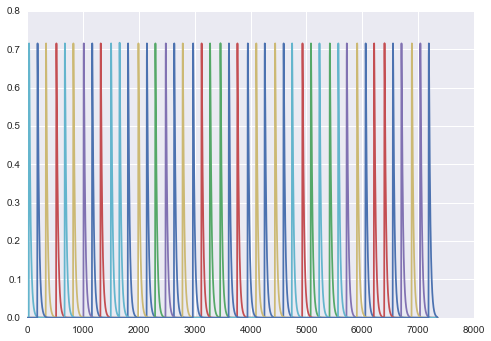

In [16]:
# convolve X with the calcium response
Xconv = np.zeros((nStims, nTimepoints), float)
for iStim in range(nStims):
    Xconv[iStim, :] = convolveStimWithCalciumResponse(X[iStim, :], roiData.index, tauOn, tauOff)
# plot convolved stimulus matrix
plt.plot(Xconv.T);

In [17]:
from thunder import RegressionModel
# setup the regression model
results = RegressionModel.load(X, 'linear').fit(roiData)
# collect results
betas = results.select('betas').collectValuesAsArray()

In [18]:
rsquare = results.select('stats').collectValuesAsArray()
resid = results.select('resid').collectValuesAsArray()

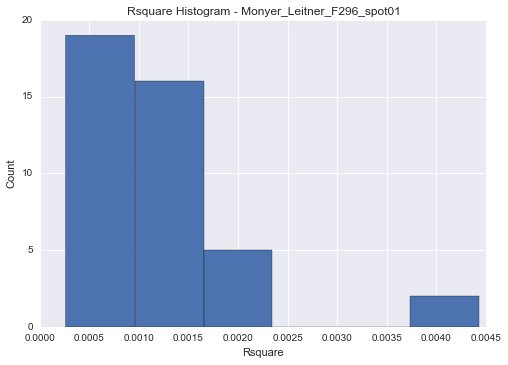

In [19]:
# histogram of rsquare values
n, bins, patches = plt.hist(rsquare, np.sqrt(len(rsquare)).astype('int'));
plt.xlabel('Rsquare');
plt.ylabel('Count');
plt.title('Rsquare Histogram - %s' % metadata['UUID']);

<matplotlib.colorbar.Colorbar instance at 0x10bc08a70>

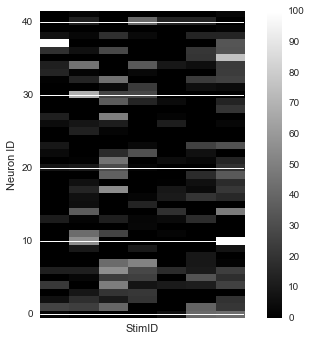

In [21]:
# beta matrix image
fig = plt.imshow(betas, cmap='gray', interpolation='nearest', aspect=0.25, origin='lower', vmin=0, vmax=100)
plt.xlabel('StimID')
plt.ylabel('Neuron ID')
plt.xticks([])
plt.colorbar();
# plt.savefig('GLM_betaImage.tiff', interpolation='nearest')

### Decoding analysis

This uses the MassUnivariate classifier implemented in thunder. It may however be more flexible and definitely more powerful to implement machine learning magic using Spark's MLlib

In [26]:
# convert to numpy array
roiData_np = roiData[:]
# peri-stimulus times (in frames)
baseFrames = 10
evokedFrames = 50
stimIx = 0
for iFrame in range(nTimepoints):
    if stimData[iFrame] > 1: # only non-air stims
        startFrame = iFrame - baseFrames
        stopFrame = iFrame + evokedFrames
        psData_stim = roiData_np[:, startFrame:stopFrame]
        stimMax = np.max(psData_stim[:, baseFrames:], 1)
        if stimIx:
            labels = np.vstack((labels, stimData[iFrame]))
            popData = np.vstack((popData, stimMax.T))
        else:
            labels = stimData[iFrame]
            popData = stimMax.T
        stimIx = stimIx + 1
labels = labels - 1

In [27]:
# setup data for population decoding
from numpy import matlib
Mshape = popData.shape
# define features (individual neurons)
features = matlib.repmat(range(Mshape[1]), 1, Mshape[0]) + 1
features = features[0]
# define samples
samples = np.linspace(1, Mshape[0], Mshape[0], dtype=int)
samples = matlib.repmat(samples, Mshape[1], 1)
samples = np.matlib.reshape(samples,(1, samples.size), order='F')
samples = samples[0]

In [28]:
# linearize popData
popData_lin = matlib.reshape(popData, (1, popData.size))
popData_lin = popData_lin[0]

In [29]:
# population decoding (NaiveBayes classifier)
# setup the classifier
from thunder.decoding.uniclassify import MassUnivariateClassifier
# params = {'labels': labels, 'samples': samples, 'features': features}
params = dict([('labels', labels), ('features', features), ('samples', samples)])
clf = MassUnivariateClassifier.load(params, "gaussnaivebayes", cv=0)

In [30]:
# convert popData into a thunder series object
from thunder.rdds.series import Series
data = Series(sc.parallelize(zip([1], [popData_lin])))
"""
zip creates a key-value pair, where 1 is the key and X the value
this is put into a Thunder series object
"""
data

Series
nrecords: None (inspect to compute)
dtype: None (inspect to compute)
dims: None (inspect to compute)
index: None (inspect to compute)

In [31]:
# fit the classifier and get results
result = clf.fit(data, [[1, 2, 3, 4, 5, 6]]).values().collect()
result[0]

array([ 0.18407597])

In [33]:
popData.shape

(37, 42)